# Statistical analysis of models for division-replication coordination

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, sparse
from scipy.optimize import minimize
import pandas as pd
import ot
import cma
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

## Data extraction

Here, we import data from Si et al. (2019), Tiruvadi et al. (2022), and Witz et al. (2019). It is important to note that in this study, we do not include the datasets STK13 Glycerol and STK13 GlucoseCas. The STK13 Glycerol dataset has been reported to present multiple issues related to likelihood maximization for both the CPM and CAM, leading their performance to be highly sensitive to the choice of distributions for $\Delta_d$, $R$, $\Delta_{id}$. Additionally, the STK13 GlucoseCas dataset contains numerous missing values, which compromise its reliability. However, both datasets have related counterparts, namely JM85 Glycerol and JM85 GluCas, as JM85 is also a BW27783 strain in which datasets, it has been cultivated in the same media.

In [2]:
data_si_mg_acet = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'MG1655 M9 acetate', header=None)
data_si_mg_acet = np.array(data_si_mg_acet)

data_si_mg_glu = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'MG1655 MOPS glucose', header=None)
data_si_mg_glu = np.array(data_si_mg_glu)
# the cell number 308 has been withdrawn because of a negative C+D period
data_si_mg_glu = np.delete(data_si_mg_glu, 308, axis = 0) 

data_si_mg_gly11aa = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'MG1655 MOPS glycerol 11aa', header=None)
data_si_mg_gly11aa = np.array(data_si_mg_gly11aa)

data_si_ncm_arg = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'NCM3722 MOPS arginine', header=None)
data_si_ncm_arg = np.array(data_si_ncm_arg)

data_si_ncm_glu12aa = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'NCM3722 MOPS glucose 12aa', header=None)
data_si_ncm_glu12aa = np.array(data_si_ncm_glu12aa)

data_si_ncm_glu = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'NCM3722 MOPS glucose', header=None)
data_si_ncm_glu = np.array(data_si_ncm_glu)

data_Tiruvadi_JM85_Gly = pd.read_csv("Fig1-2_Data/JM85(ssb-mYpet)_Gly.txt", sep = '\t', header = None)
data_Tiruvadi_JM85_Gly = np.array(data_Tiruvadi_JM85_Gly)

data_Tiruvadi_STK13_Ace = pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_Ace.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_Ace = np.array(data_Tiruvadi_STK13_Ace)

data_Tiruvadi_STK13_AlaTrE = pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_AlaTrE.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_AlaTrE = np.array(data_Tiruvadi_STK13_AlaTrE)

data_Tiruvadi_STK13_Glu = pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_Glu.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_Glu = np.array(data_Tiruvadi_STK13_Glu)

data_Tiruvadi_STK13_GlyCas= pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_GlyCas.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_GlyCas = np.array(data_Tiruvadi_STK13_GlyCas)

data_Tiruvadi_STK13_GlyTrE= pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_GlyTrE.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_GlyTrE = np.array(data_Tiruvadi_STK13_GlyTrE)

data_Tiruvadi_STK13_Man= pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_Man.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_Man = np.array(data_Tiruvadi_STK13_Man)
data_Tiruvadi_STK13_Man = np.delete(data_Tiruvadi_STK13_Man, (191, 199, 275), axis = 0)

data_Tiruvadi_JM85_GluCas = pd.read_csv("Fig1-2_Data/JM85(ssb-mYpet)_GluCas.txt", sep = '\t', header = None)
data_Tiruvadi_JM85_GluCas = np.array(data_Tiruvadi_JM85_GluCas)

data_witz = pd.read_csv('Fig1_2_3.csv', header = None) 
[Lb, dL, Li, Li_prev, dLambda_if, lambda_inv, Tid, dLambda_id, Lb_mother, condition] = range(0, 10)

Then we define a function that takes into argument the dataset (or the growth condition either 'glycerol', 'glucose' or 'glucose8a' if the data comes from Witz et al. (2019)), and returns cell variables.

Examples for use:

extract_data(data_si_mops_acet, 'si')

extract_data(data_Tiruvadi_JM85_GluCas, 'tiruvadi')

extract_data('glycerol', 'witz')

The extracted cell variables are 
- v, the volume at birth ($V_b^{(\bullet)}$)
- v_tild, the volume per origin at replication initiation ($\tilde{V}_i^{(\bullet)}$)
- V, the next volume at birth ($V_b^{(\bullet+1)}$)
- TCD, the C+D period duration ($T_b^{(\bullet+1)}-T_i^{(\bullet)}$)

In [3]:
def extract_data(data_or_cdt, author):
    if author == 'si':
        data = data_or_cdt
        v = data[1:, data[0] == 'newborn size (micron)'].astype(float)
        v_tild = data[1:, data[0] == 'initiation size per ori (micron)'].astype(float)/2.
        V = data[1:, data[0] == 'division size (micron)'].astype(float)/2.
        TCD = data[1:, data[0] == 'tau_cyc (minute)'].astype(float)/60.
        return [v, v_tild, V, TCD]
    
    elif author == 'tiruvadi':
        data = data_or_cdt
        v = data[1:, data[0] == 'Lb'].astype(float)
        v_tild = data[1:, data[0] == 'Lri'].astype(float)/2.
        V = data[1:, data[0] == 'Ld'].astype(float)/2.
        Tri = data[1:, data[0] == 'Tri'].astype(float)
        Td = data[1:, data[0] == 'Td'].astype(float)
        TCD = (Td - Tri)/60.
        return [v, v_tild, V, TCD]
    
    elif author == 'witz':
        data = data_witz[data_witz[condition] == data_or_cdt]
        data = data.dropna(subset = (Lb, dL, Li, Tid))
        data = data.to_numpy()
        data = data[:,:-1].astype(float)
        TCD = data[:, Tid]/60.
        v = data[:, Lb]
        V = (v + data[:, dL])/2.
        v_tild = data[:, Li]/2.
        return [v, v_tild, V, TCD]

For every dataset we apply the function extract_data. The following codes will involve functions taking in argument the following variables as 'data'. 

In [4]:
MG_acet = extract_data(data_si_mg_acet, 'si')
MG_gly11a = extract_data(data_si_mg_gly11aa, 'si')
MG_glu = extract_data(data_si_mg_glu, 'si')

NCM_arg = extract_data(data_si_ncm_arg, 'si')
NCM_glu = extract_data(data_si_ncm_glu, 'si')
NCM_glu12a = extract_data(data_si_ncm_glu12aa, 'si')

JM_gly = extract_data(data_Tiruvadi_JM85_Gly, 'tiruvadi')
JM_gluCas = extract_data(data_Tiruvadi_JM85_GluCas, 'tiruvadi')

STK_acet = extract_data(data_Tiruvadi_STK13_Ace, 'tiruvadi')
STK_alaTre = extract_data(data_Tiruvadi_STK13_AlaTrE, 'tiruvadi')
STK_glu = extract_data(data_Tiruvadi_STK13_Glu, 'tiruvadi')
STK_glyCas = extract_data(data_Tiruvadi_STK13_GlyCas, 'tiruvadi')
STK_glyTre = extract_data(data_Tiruvadi_STK13_GlyTrE, 'tiruvadi')
STK_man = extract_data(data_Tiruvadi_STK13_Man, 'tiruvadi')

BW_gly = extract_data('glycerol', 'witz')
BW_glu = extract_data('glucose', 'witz')
BW_glu8a = extract_data('glucose8a', 'witz')

DATA = [[MG_acet, MG_gly11a, MG_glu],
      [NCM_arg, NCM_glu, NCM_glu12a],
      [BW_gly, BW_glu, BW_glu8a],
      [STK_acet, STK_alaTre, STK_man, JM_gly, STK_glyTre, STK_glu, STK_glyCas, JM_gluCas]]

Labels = [['MG acet', 'MG gly11aa', 'MG glu'],
        ['NCM arg', 'NCM glu', 'NCM glu12aa'],
        ['BW gly', 'BW glu', 'BW glu8a'],
        ['STK acet', 'STK alaTrE', 'STK man', 'JM gly', 'STK glyTre', 'STK glu', 'STK glyCas', 'JM gluCas']]

## Parameters estimation and BIC computation

Estimation of the parameters of the law of $\Delta_d$ that is assumed to be a Generalized Gamma distriution, and computation of the BIC score over the conditional density of the volume at the next birth according to the DIAM.

In [5]:
def estim_param_DIAM(data):
    [v, v_tild, V, TCD] = data
    a, c ,_,scale = stats.gengamma.fit(2*V - v, floc = 0)
    BIC = - np.sum(np.log(2*stats.gengamma.pdf(2*V - v, a = a, c = c, scale = scale))) + 3*np.log(np.size(v))/2.
    return [a, c, scale, BIC]

Same for the RDAM.

In [6]:
def estim_param_RDAM(data):
    [v, v_tild, V, TCD] = data
    a, c ,_,scale = stats.gengamma.fit(V - v_tild, floc = 0)
    BIC = - np.sum(np.log(stats.gengamma.pdf(V - v_tild, a = a, c = c, scale = scale))) + 3*np.log(np.size(v))/2.
    return [a, c, scale, BIC]

The parameters estimation of the  CPM with as argument the law of $\Delta_d$ that can be either Gamma (stats.gamma) or Log normal (stats.lognorm) and the law of $R$ that can be either Gamma or Log normal. The optimization algorithm used in this code is the Nelder–Mead method. For four out of 10 datasets from Tiruvadi et al. the optimization has not succeded suggesting a defect in the data, that we have not been able to solve. Thus the four datasets have been removed from the study.

In [7]:
def estim_param_CPM(data, law_Delta_d, law_R):
    [v, v_tild, V, TCD] = data
    lamb = np.log(V/v_tild)/TCD
    Delta_app = 2*V - v
    def f(X):
        [a_d, s_d, a_r, s_r] = X
        f_Dd = law_Delta_d.pdf(Delta_app, a_d, scale = s_d)
        F_Dd = law_Delta_d.cdf(Delta_app, a_d, scale = s_d)
        f_R = law_R.pdf(TCD, a_r, scale = s_r)
        F_R = law_R.cdf(TCD, a_r, scale = s_r)
        Y = 2*f_Dd*F_R + F_Dd*f_R/(lamb*V)
        return - np.sum(np.log(Y))
    moy_d = np.mean(Delta_app)
    var_d = np.var(Delta_app)
    moy_r = np.mean(TCD)
    var_r = np.var(TCD)
    # The initialization of the optimization is based on parameter estimation with 
    # the method of moments over Delta_app and TCD
    if law_Delta_d == stats.gamma:
        a_d = moy_d**2/var_d
        scale_d = var_d/moy_d
        if law_R == stats.gamma:
            a_r = moy_r**2/var_r
            scale_r = var_r/moy_r
            X0 = [a_d, scale_d, a_r, scale_r]
        elif law_R == stats.lognorm:
            a_r = np.sqrt(np.log(var_r/moy_r**2 + 1))
            scale_r = moy_r
            X0 = [a_d, scale_d, a_r, scale_r]
    elif law_Delta_d == stats.lognorm:
        a_d = np.sqrt(np.log(var_d/moy_d**2 + 1))
        scale_d = moy_d
        if law_R == stats.gamma:
            a_r = moy_r**2/var_r
            scale_r = var_r/moy_r
            X0 = [a_d, scale_d, a_r, scale_r]
        elif law_R == stats.lognorm:
            a_r = np.sqrt(np.log(var_r/moy_r**2 + 1))
            scale_r = moy_r
            X0 = [a_d, scale_d, a_r, scale_r]
    #results = cma.fmin(f, X0, sigma0 = 1, options = {'verbose': -9, 'seed': 123})
    #BIC = results[1] + 2*np.log(np.size(v))
    #return [results[0], BIC]
    results = minimize(f, X0, method = 'Nelder-Mead')
    BIC = results.fun + 2*np.log(np.size(v))
    return [results.x, results.success, BIC]

Same for CAM.

In [8]:
def estim_param_CAM(data, law_Delta_d, law_Delta_id):
    [v, v_tild, V, TCD] = data
    Delta_app = 2*V - v
    Delta_id_app = V - v_tild
    def f(X):
        [a_d, s_d, a_r, s_r] = X
        f_Dd = law_Delta_d.pdf(Delta_app, a_d, scale = s_d)
        F_Dd = law_Delta_d.cdf(Delta_app, a_d, scale = s_d)
        f_Did = law_Delta_id.pdf(Delta_id_app, a_r, scale = s_r)
        F_Did = law_Delta_id.cdf(Delta_id_app, a_r, scale = s_r)
        Y = 2*f_Dd*F_Did + F_Dd*f_Did
        return - np.sum(np.log(Y))
    moy_d = np.mean(Delta_app)
    var_d = np.var(Delta_app)
    moy_id = np.mean(Delta_id_app)
    var_id = np.var(Delta_id_app)
    # The initialization of the optimization is based on parameter estimation with 
    # the method of moments over Delta_app and Delta_id_app
    if law_Delta_d == stats.gamma:
        a_d = moy_d**2/var_d
        scale_d = var_d/moy_d
        if law_Delta_id == stats.gamma:
            a_id = moy_id**2/var_id
            scale_id = var_id/moy_id
            X0 = [a_d, scale_d, a_id, scale_id]
        elif law_Delta_id == stats.lognorm:
            a_id = np.sqrt(np.log(var_id/moy_id**2 + 1))
            scale_id = moy_id
            X0 = [a_d, scale_d, a_id, scale_id]
    elif law_Delta_d == stats.lognorm:
        a_d = np.sqrt(np.log(var_d/moy_d**2 + 1))
        scale_d = moy_d
        if law_Delta_id == stats.gamma:
            a_id = moy_id**2/var_id
            scale_id = var_id/moy_id
            X0 = [a_d, scale_d, a_id, scale_id]
        elif law_Delta_id == stats.lognorm:
            a_id = np.sqrt(np.log(var_id/moy_id**2 + 1))
            scale_id = moy_id
            X0 = [a_d, scale_d, a_id, scale_id]
    #results = cma.fmin(f, X0, sigma0 = 1, options = {'verbose': -9, 'seed': 123})
    #BIC = results[1] + 2*np.log(np.size(v))
    #return [results[0], BIC]
    results = minimize(f, X0, method = 'Nelder-Mead')
    BIC = results.fun + 2*np.log(np.size(v))
    return [results.x, results.success, BIC]

Here we investigate for $\Delta_d$, $R$, $\Delta_{id}$ the combination of laws (either Gamma or Lognormal) for which the CPM and the CAM show the best likelihoods.

In [9]:
BIC_densities_CAM = []
BIC_densities_CPM = []
for i in range(4):
    for j in range(len(DATA[i])):
        Dd_gam_Did_gam = estim_param_CAM(DATA[i][j], stats.gamma, stats.gamma)
        if not Dd_gam_Did_gam[1]:
            print('The maximisation of the likelihood for the CAM has failed for the dataset', Labels[i][j], 'when $\Delta_d \sim Gamma, \Delta_{id} \sim Gamma$')
        Dd_lnorm_Did_gam = estim_param_CAM(DATA[i][j], stats.lognorm, stats.gamma)
        if not Dd_lnorm_Did_gam[1]:
            print('The maximisation of the likelihood for the CAM has failed for the dataset', Labels[i][j] , 'when $\Delta_d \sim lognorm, \Delta_{id} \sim Gamma$')
        Dd_gam_Did_lnorm = estim_param_CAM(DATA[i][j], stats.gamma, stats.lognorm)
        if not Dd_gam_Did_lnorm[1]:
            print('The maximisation of the likelihood for the CAM has failed for the dataset', Labels[i][j], 'when $\Delta_d \sim Gamma, \Delta_{id} \sim lognorm$')
        Dd_lnorm_Did_lnorm = estim_param_CAM(DATA[i][j], stats.lognorm, stats.lognorm)
        if not Dd_lnorm_Did_lnorm[1]:
            print('The maximisation of the likelihood for the CAM has failed for the dataset', Labels[i][j], 'when $\Delta_d \sim lognorm, \Delta_{id} \sim lognorm$')
        Dd_gam_R_gam = estim_param_CPM(DATA[i][j], stats.gamma, stats.gamma)
        if not Dd_gam_R_gam[1]:
            print('The maximisation of the likelihood for the CPM has failed for the dataset', Labels[i][j], 'when $\Delta_d \sim \Gamma, R \sim Gamma$')
        Dd_lnorm_R_gam = estim_param_CPM(DATA[i][j], stats.lognorm, stats.gamma)
        if not Dd_lnorm_R_gam[1]:
            print('The maximisation of the likelihood for the CPM has failed for the dataset', Labels[i][j] , 'when $\Delta_d \sim lognorm, R \sim Gamma$')
        Dd_gam_R_lnorm = estim_param_CPM(DATA[i][j], stats.gamma, stats.lognorm)
        if not Dd_gam_R_lnorm[1]:
            print('The maximisation of the likelihood for the CPM has failed for the dataset', Labels[i][j], 'when $\Delta_d \sim Gamma, R \sim lognorm$')
        Dd_lnorm_R_lnorm = estim_param_CPM(DATA[i][j], stats.lognorm, stats.lognorm)
        if not Dd_lnorm_R_lnorm[1]:
            print('The maximisation of the likelihood for the CPM has failed for the dataset', Labels[i][j], 'when $\Delta_d \sim lognorm, R \sim lognorm$')
        BIC_densities_CAM.append([Dd_gam_Did_gam[-1], Dd_lnorm_Did_gam[-1], Dd_gam_Did_lnorm[-1], Dd_lnorm_Did_lnorm[-1]])
        BIC_densities_CPM.append([Dd_gam_R_gam[-1], Dd_lnorm_R_gam[-1], Dd_gam_R_lnorm[-1], Dd_lnorm_R_lnorm[-1]])

BIC_densities_CAM = np.array(BIC_densities_CAM)
BIC_densities_CPM = np.array(BIC_densities_CPM)

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_67491/1882013329.py:12: RuntimeWarning: divide by zero encountered in log
  return - np.sum(np.log(Y))


The maximisation of the likelihood for the CPM has failed for the dataset MG gly11aa when $\Delta_d \sim \Gamma, R \sim Gamma$
The maximisation of the likelihood for the CAM has failed for the dataset STK alaTrE when $\Delta_d \sim Gamma, \Delta_{id} \sim Gamma$
The maximisation of the likelihood for the CAM has failed for the dataset STK alaTrE when $\Delta_d \sim Gamma, \Delta_{id} \sim lognorm$


[-6.60273562 -2.76765083 -4.92383311 -5.78563996]


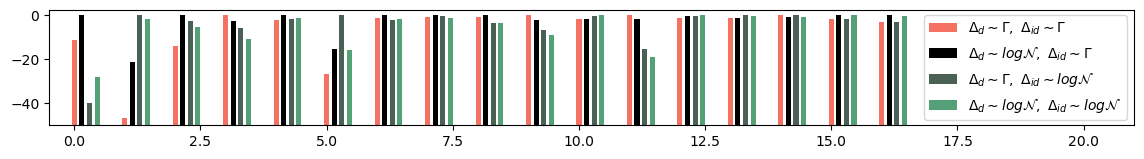

In [10]:
colorCAM = ['#F57164', 'k', '#4C6155', '#55A177']
Delta_BIC_densities_CAM = np.min(BIC_densities_CAM, axis = 1)[:,None] - BIC_densities_CAM
print(np.mean(Delta_BIC_densities_CAM, axis = 0))
plt.figure(figsize = (14, 1.5))
bottom = 50
plt.bar(np.arange(17), Delta_BIC_densities_CAM[:,0] + bottom, width = 0.1, bottom = -bottom, label = '$\Delta_d \sim \Gamma, \ \Delta_{id} \sim \Gamma$', color = colorCAM[0])
plt.bar(np.arange(17)+0.15, Delta_BIC_densities_CAM[:,1] + bottom, width = 0.1, bottom = -bottom, label = '$\Delta_d \sim log\mathcal{N}, \ \Delta_{id} \sim \Gamma$', color = colorCAM[1])
plt.bar(np.arange(17)+0.3, Delta_BIC_densities_CAM[:,2] + bottom, width = 0.1, bottom = -bottom, label = '$\Delta_d \sim \Gamma, \ \Delta_{id} \sim log\mathcal{N}$', color = colorCAM[2])
plt.bar(np.arange(17)+0.45, Delta_BIC_densities_CAM[:,3] + bottom, width = 0.1, bottom = -bottom, label = '$\Delta_d \sim log\mathcal{N}, \ \Delta_{id} \sim log\mathcal{N}$', color = colorCAM[3])
plt.xlim(-0.5, 21)
plt.legend(loc = 'right')

We see that the combination $\Delta_d \sim log\mathcal{N}$ and $ \Delta_{id} \sim \Gamma$ is the best laws combination in average for the CAM. 

[-6.63276615 -2.3635164  -8.39066625 -3.49187726]


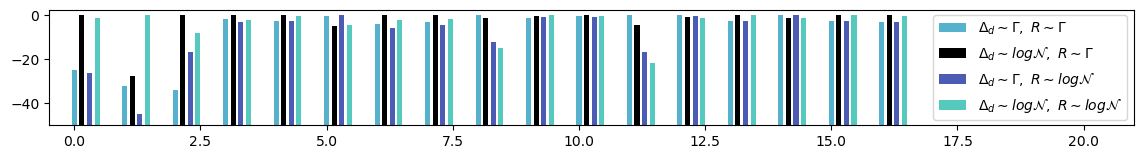

In [11]:
colorCPM = ['#56B2CC', 'k', '#4C5CB5', '#55C9BE']
Delta_BIC_densities_CPM = np.min(BIC_densities_CPM, axis = 1)[:,None] - BIC_densities_CPM
print(np.mean(Delta_BIC_densities_CPM, axis = 0))
plt.figure(figsize = (14, 1.5))
bottom = 50
plt.bar(np.arange(17), Delta_BIC_densities_CPM[:,0] + bottom, width = 0.1, bottom = -bottom, label = '$\Delta_d \sim \Gamma, \ R \sim \Gamma$', color = colorCPM[0])
plt.bar(np.arange(17)+0.15, Delta_BIC_densities_CPM[:,1] + bottom, width = 0.1, bottom = -bottom, label = '$\Delta_d \sim log\mathcal{N}, \ R \sim \Gamma$', color = colorCPM[1])
plt.bar(np.arange(17)+0.3, Delta_BIC_densities_CPM[:,2] + bottom, width = 0.1, bottom = -bottom, label = '$\Delta_d \sim \Gamma, \ R \sim log\mathcal{N}$', color = colorCPM[2])
plt.bar(np.arange(17)+0.45, Delta_BIC_densities_CPM[:,3] + bottom, width = 0.1, bottom = -bottom, label = '$\Delta_d \sim log\mathcal{N}, \ R \sim log\mathcal{N}$', color = colorCPM[3])
plt.xlim(-0.5, 21)
plt.legend(loc = 'right')

We see that the combination $\Delta_d \sim log\mathcal{N}$ and $ R\sim \Gamma$ is the best laws combination in average for the CPM. 

Here we estimate the model's parameters and compute their respective BIC score.

In [12]:
BIC = [['', 'DIAM', 'RDAM', 'CPM', 'CAM']]
Estimated_parameters = []
for i in range(4):
    param = []
    for j in range(len(DATA[i])):
        Res_bic_DIAM = estim_param_DIAM(DATA[i][j])
        Res_bic_RDAM = estim_param_RDAM(DATA[i][j])
        Res_bic_CPM = estim_param_CPM(DATA[i][j], stats.lognorm, stats.gamma)
        Res_bic_CAM = estim_param_CAM(DATA[i][j], stats.lognorm, stats.gamma)
        if not Res_bic_CPM[1]:
            print('The maximisation of the likelihood for the CPM has failed for the dataset', Labels[i][j])
        if not Res_bic_CAM[1]:
            print('The maximisation of the likelihood for the CAM has failed for the dataset', Labels[i][j])
        BIC.append([Labels[i][j], Res_bic_DIAM[-1], Res_bic_RDAM[-1], Res_bic_CPM[-1], Res_bic_CAM[-1]])
        param.append([Res_bic_DIAM[:-1], Res_bic_RDAM[:-1], list(Res_bic_CPM[0]), list(Res_bic_CAM[0])])
    Estimated_parameters.append(param)
BIC = np.array(BIC, dtype = object)
pd.DataFrame(data = BIC[1:,1:], index = BIC[1:,0], columns = BIC[0, 1:])

,DIAM,RDAM,CPM,CAM
MG acet,-378.640886,-577.222728,-577.403108,-850.412584
MG gly11aa,245.229483,501.469672,224.298846,182.172451
MG glu,-41.29824,206.911678,-89.618679,-155.165864
NCM arg,-1431.960097,-1537.511514,-1844.655778,-1630.98063
NCM glu,-719.01261,-603.79414,-805.059834,-767.741999
NCM glu12aa,-6.620338,262.228575,-37.755186,-27.132042
BW gly,-413.034199,-447.09653,-582.859675,-542.653324
BW glu,-261.20046,-41.658124,-337.164932,-269.98065
BW glu8a,13.938788,139.020364,-44.822811,-14.977322
STK acet,-222.535637,-315.49339,-293.745544,-315.347197


## Wasserstein distances computation

Definition of a funcion computing the empirical Wasserstein distance between 2-dimentional sets of data.

In [13]:
def wasserstein_distance(X, Y):
    n_X = np.size(X[:,0])
    n_Y = np.size(Y[:,0])
    cost_matrix = ot.dist(X, Y, metric='euclidean')
    weights_X = np.ones(n_X) / n_X
    weights_Y = np.ones(n_Y) / n_Y
    return ot.emd2(weights_X, weights_Y, cost_matrix)

In [14]:
def Wasserstein_DIAM(data, param, nb_sim):
    np.random.seed(121)
    [v, v_tild, V, TCD] = data
    lamb = np.log(V/v_tild)/TCD
    N = np.size(v)
    v_tild = np.reshape(v_tild, (N,1))
    V = np.reshape(V, (N,1))
    v = np.reshape(v, (N,1))
    lamb = np.reshape(lamb, (N,1))
    dist_vi = []
    dist_vb = []
    dist_lamb = []
    [a, c, scale]  = param
    for n in range(nb_sim):
        Delta_d = stats.gengamma.rvs(size = (N,1), a = a, c = c, scale = scale)
        Vb_sim = (v + Delta_d)/2.
        dist_vi.append(wasserstein_distance(np.concatenate((Vb_sim, v_tild), axis = 1), np.concatenate((V, v_tild), axis = 1)))
        dist_vb.append(wasserstein_distance(np.concatenate((Vb_sim, v), axis = 1), np.concatenate((V, v), axis = 1)))
        dist_lamb.append(wasserstein_distance(np.concatenate((Vb_sim, lamb), axis = 1), np.concatenate((V, lamb), axis = 1)))
    dist_vi = np.array(dist_vi)
    dist_vb = np.array(dist_vb)
    dist_lamb = np.array(dist_lamb)
    return [[np.mean(dist_vb), np.std(dist_vb)], [np.mean(dist_vi), np.std(dist_vi)], [np.mean(dist_lamb), np.std(dist_lamb)]]

In [15]:
def Wasserstein_RDAM(data, param, nb_sim):
    np.random.seed(122)
    [v, v_tild, V, TCD] = data
    lamb = np.log(V/v_tild)/TCD
    N = np.size(v)
    v_tild = np.reshape(v_tild, (N,1))
    V = np.reshape(V, (N,1))
    v = np.reshape(v, (N,1))
    lamb = np.reshape(lamb, (N,1))
    dist_vi = []
    dist_vb = []
    dist_lamb = []
    [a, c, scale]  = param
    for n in range(nb_sim):
        Delta_id = stats.gengamma.rvs(size = (N,1), a = a, c = c, scale = scale)
        Vb_sim = v_tild + Delta_id
        dist_vi.append(wasserstein_distance(np.concatenate((Vb_sim, v_tild), axis = 1), np.concatenate((V, v_tild), axis = 1)))
        dist_vb.append(wasserstein_distance(np.concatenate((Vb_sim, v), axis = 1), np.concatenate((V, v), axis = 1)))
        dist_lamb.append(wasserstein_distance(np.concatenate((Vb_sim, lamb), axis = 1), np.concatenate((V, lamb), axis = 1)))
    dist_vi = np.array(dist_vi)
    dist_vb = np.array(dist_vb)
    dist_lamb = np.array(dist_lamb)
    return [[np.mean(dist_vb), np.std(dist_vb)], [np.mean(dist_vi), np.std(dist_vi)], [np.mean(dist_lamb), np.std(dist_lamb)]]

In [16]:
def Wasserstein_CPM(data, param, nb_sim):
    np.random.seed(123)
    [v, v_tild, V, TCD] = data
    lamb = np.log(V/v_tild)/TCD
    N = np.size(v)
    v_tild = np.reshape(v_tild, (N,1))
    V = np.reshape(V, (N,1))
    v = np.reshape(v, (N,1))
    lamb = np.reshape(lamb, (N,1))
    dist_vi = []
    dist_vb = []
    dist_lamb = []
    [a_d, s_d, a_r, s_r]  = param
    for n in range(nb_sim):
        R = stats.gamma.rvs(size = (N,1), a = a_r, scale = s_r)
        Delta_d = stats.lognorm.rvs(size = (N,1), s = a_d, scale = s_d)
        Vb_sim = np.maximum(v_tild*np.exp(lamb*R), (v + Delta_d)/2.)
        dist_vi.append(wasserstein_distance(np.concatenate((Vb_sim, v_tild), axis = 1), np.concatenate((V, v_tild), axis = 1)))
        dist_vb.append(wasserstein_distance(np.concatenate((Vb_sim, v), axis = 1), np.concatenate((V, v), axis = 1)))
        dist_lamb.append(wasserstein_distance(np.concatenate((Vb_sim, lamb), axis = 1), np.concatenate((V, lamb), axis = 1)))
    dist_vi = np.array(dist_vi)
    dist_vb = np.array(dist_vb)
    dist_lamb = np.array(dist_lamb)
    return [[np.mean(dist_vb), np.std(dist_vb)], [np.mean(dist_vi), np.std(dist_vi)], [np.mean(dist_lamb), np.std(dist_lamb)]]

In [17]:
def Wasserstein_CAM(data, param, nb_sim):
    np.random.seed(124)
    [v, v_tild, V, TCD] = data
    lamb = np.log(V/v_tild)/TCD
    N = np.size(v)
    v_tild = np.reshape(v_tild, (N,1))
    V = np.reshape(V, (N,1))
    v = np.reshape(v, (N,1))
    lamb = np.reshape(lamb, (N,1))
    dist_vi = []
    dist_vb = []
    dist_lamb = []
    [a_d, s_d, a_id, s_id]  = param
    for n in range(nb_sim):
        Delta_id = stats.gamma.rvs(size = (N,1), a = a_id, scale = s_id)
        Delta_d = stats.lognorm.rvs(size = (N,1), s = a_d, scale = s_d)
        Vb_sim = np.maximum(v_tild + Delta_id, (v + Delta_d)/2.)
        dist_vi.append(wasserstein_distance(np.concatenate((Vb_sim, v_tild), axis = 1), np.concatenate((V, v_tild), axis = 1)))
        dist_vb.append(wasserstein_distance(np.concatenate((Vb_sim, v), axis = 1), np.concatenate((V, v), axis = 1)))
        dist_lamb.append(wasserstein_distance(np.concatenate((Vb_sim, lamb), axis = 1), np.concatenate((V, lamb), axis = 1)))
    dist_vi = np.array(dist_vi)
    dist_vb = np.array(dist_vb)
    dist_lamb = np.array(dist_lamb)
    return [[np.mean(dist_vb), np.std(dist_vb)], [np.mean(dist_vi), np.std(dist_vi)], [np.mean(dist_lamb), np.std(dist_lamb)]]

In the next command we compute every Wasserstein distances. Note that this computation may take some time. 

In [18]:
Wass_dist_vb = []
Wass_dist_vi = []
Wass_dist_lamb = []
print('0/17 datasets done', end='\r')
for i in range(4):
    for j in range(len(DATA[i])):
        Res_wass_DIAM = Wasserstein_DIAM(DATA[i][j], Estimated_parameters[i][j][0], 100)
        Res_wass_RDAM = Wasserstein_RDAM(DATA[i][j], Estimated_parameters[i][j][1], 100)
        Res_wass_CPM = Wasserstein_CPM(DATA[i][j], Estimated_parameters[i][j][2], 100)
        Res_wass_CAM = Wasserstein_CAM(DATA[i][j], Estimated_parameters[i][j][3], 100)
        Wass_dist_vb.append([Res_wass_DIAM[0], Res_wass_RDAM[0], Res_wass_CPM[0], Res_wass_CAM[0]])
        Wass_dist_vi.append([Res_wass_DIAM[1], Res_wass_RDAM[1], Res_wass_CPM[1], Res_wass_CAM[1]])
        Wass_dist_lamb.append([Res_wass_DIAM[2], Res_wass_RDAM[2], Res_wass_CPM[2], Res_wass_CAM[2]])
        print(3*i+(j+1), '/17 datasets done', end='\r')

Wass_dist_vb = np.array(Wass_dist_vb)
Wass_dist_vi = np.array(Wass_dist_vi)
Wass_dist_lamb = np.array(Wass_dist_lamb)

Wasserstein distance between simulated and experimental joint distributions $(V_b^{(\bullet +1)}, V_b^{(\bullet)})$

In [19]:
columns = pd.MultiIndex.from_product([['DIAM','RDAM','CPM', 'CAM'], ['mean','std']])
pd.DataFrame(data = Wass_dist_vb.reshape(17, 8), index = BIC[1:,0], columns = columns)

DIAM                RDAM                 CPM            \
                 mean       std      mean       std      mean       std   
MG acet      0.046493  0.002698  0.056534  0.002681  0.039506  0.002549   
MG gly11aa   0.052945  0.002705  0.133940  0.005175  0.049393  0.002775   
MG glu       0.041622  0.002566  0.103335  0.004197  0.037540  0.002682   
NCM arg      0.015067  0.000886  0.022776  0.001271  0.018257  0.001137   
NCM glu      0.024242  0.001805  0.049440  0.002310  0.024351  0.001919   
NCM glu12aa  0.040954  0.002478  0.110392  0.004254  0.035591  0.001998   
BW gly       0.033741  0.002377  0.045986  0.002772  0.031882  0.001819   
BW glu       0.051798  0.003569  0.101415  0.004503  0.050307  0.002963   
BW glu8a     0.060423  0.004437  0.091573  0.005064  0.065178  0.004556   
STK acet     0.034199  0.002444  0.032861  0.002202  0.030726  0.002203   
STK alaTrE   0.058108  0.005319  0.043955  0.002433  0.053274  0.004439   
STK man      0.055680  0.004992  0.053626  0.003164  0.076386  0.008903   
JM gly       0.045121  0.003757  0.051902  0.003404  0.043600  0.003389   
STK glyTre   0.046566  0.003650  0.043579  0.003513  0.040998  0.003016   
STK glu      0.056886  0.005472  0.050799  0.003737  0.062098  0.005661   
STK glyCas   0.077785  0.006096  0.147946  0.011745  0.088232  0.008589   
JM gluCas    0.078237  0.006057  0.151200  0.012280  0.076523  0.005670   

                  CAM            
                 mean       std  
MG acet      0.026923  0.001377  
MG gly11aa   0.043667  0.002183  
MG glu       0.034503  0.002103  
NCM arg      0.013668  0.000655  
NCM glu      0.021782  0.001070  
NCM glu12aa  0.038754  0.002145  
BW gly       0.028423  0.001395  
BW glu       0.047865  0.002948  
BW glu8a     0.046298  0.003023  
STK acet     0.029958  0.001673  
STK alaTrE   0.043301  0.002547  
STK man      0.050819  0.003727  
JM gly       0.040639  0.002321  
STK glyTre   0.029467  0.001638  
STK glu      0.048538  0.003584  
STK glyCas   0.076443  0.006981  
JM gluCas    0.077275  0.005864

Wasserstein distance between simulated and experimental joint distributions $(V_b^{(\bullet +1)}, \tilde{V}_i^{(\bullet)})$

In [20]:
pd.DataFrame(data = Wass_dist_vi.reshape(17, 8), index = BIC[1:,0], columns = columns)

DIAM                RDAM                 CPM            \
                 mean       std      mean       std      mean       std   
MG acet      0.063339  0.002332  0.039293  0.002235  0.049510  0.002272   
MG gly11aa   0.043208  0.003455  0.048478  0.004497  0.039620  0.003315   
MG glu       0.036214  0.002861  0.038867  0.003746  0.030492  0.002954   
NCM arg      0.024273  0.001018  0.016028  0.001352  0.017103  0.001094   
NCM glu      0.019509  0.001729  0.014326  0.001248  0.018417  0.001992   
NCM glu12aa  0.027465  0.003529  0.032948  0.003767  0.019904  0.002511   
BW gly       0.042079  0.002234  0.031353  0.002557  0.028458  0.002260   
BW glu       0.039834  0.003494  0.053086  0.004086  0.037909  0.003068   
BW glu8a     0.045579  0.004191  0.047491  0.004019  0.046960  0.004665   
STK acet     0.048906  0.003237  0.027119  0.002141  0.037185  0.003254   
STK alaTrE   0.050799  0.004611  0.033742  0.002182  0.043189  0.004174   
STK man      0.045025  0.004481  0.039689  0.003265  0.066723  0.008699   
JM gly       0.051615  0.003894  0.031412  0.001840  0.044294  0.003865   
STK glyTre   0.040805  0.003916  0.028033  0.003091  0.034571  0.003373   
STK glu      0.040596  0.005059  0.038002  0.004177  0.046138  0.005640   
STK glyCas   0.054238  0.006722  0.050450  0.006649  0.066343  0.008527   
JM gluCas    0.060969  0.005329  0.129922  0.012899  0.060291  0.004553   

                  CAM            
                 mean       std  
MG acet      0.021035  0.001758  
MG gly11aa   0.028101  0.002400  
MG glu       0.023894  0.001854  
NCM arg      0.011262  0.000562  
NCM glu      0.014648  0.001067  
NCM glu12aa  0.021180  0.001804  
BW gly       0.023156  0.001570  
BW glu       0.036103  0.002797  
BW glu8a     0.032337  0.002839  
STK acet     0.025134  0.001897  
STK alaTrE   0.033486  0.002544  
STK man      0.040428  0.003991  
JM gly       0.031682  0.002186  
STK glyTre   0.021396  0.001521  
STK glu      0.036610  0.004144  
STK glyCas   0.051652  0.007307  
JM gluCas    0.057977  0.005412

Wasserstein distance between simulated and experimental joint distributions $(V_b^{(\bullet +1)}, \lambda^{(\bullet)})$

In [21]:
pd.DataFrame(data = Wass_dist_lamb.reshape(17, 8), index = BIC[1:,0], columns = columns)

DIAM                RDAM                 CPM            \
                 mean       std      mean       std      mean       std   
MG acet      0.040257  0.002899  0.035244  0.002687  0.036817  0.002778   
MG gly11aa   0.051155  0.003474  0.061589  0.004544  0.047888  0.003157   
MG glu       0.043503  0.002852  0.048929  0.003496  0.041870  0.003095   
NCM arg      0.016365  0.001066  0.024713  0.001052  0.016768  0.001113   
NCM glu      0.020147  0.001697  0.026601  0.001392  0.019582  0.001885   
NCM glu12aa  0.029046  0.003295  0.038211  0.003300  0.021982  0.002466   
BW gly       0.028858  0.002448  0.033793  0.002502  0.025769  0.002045   
BW glu       0.049290  0.003101  0.060421  0.003667  0.040580  0.002886   
BW glu8a     0.058749  0.003249  0.067636  0.003762  0.052305  0.004622   
STK acet     0.020599  0.003202  0.019975  0.002785  0.018569  0.003387   
STK alaTrE   0.035643  0.004570  0.029183  0.002564  0.032853  0.004589   
STK man      0.043461  0.004693  0.043821  0.003124  0.063409  0.008595   
JM gly       0.029818  0.004089  0.022592  0.002256  0.030035  0.004077   
STK glyTre   0.032293  0.003979  0.027992  0.003020  0.030103  0.003375   
STK glu      0.040775  0.004969  0.041899  0.004258  0.044903  0.005825   
STK glyCas   0.087905  0.006009  0.121578  0.007380  0.074393  0.008216   
JM gluCas    0.062751  0.005491  0.116954  0.011582  0.058471  0.005282   

                  CAM            
                 mean       std  
MG acet      0.017801  0.001660  
MG gly11aa   0.038880  0.002227  
MG glu       0.031344  0.001761  
NCM arg      0.019335  0.000795  
NCM glu      0.019158  0.001036  
NCM glu12aa  0.023765  0.001845  
BW gly       0.027330  0.001695  
BW glu       0.047241  0.002787  
BW glu8a     0.052692  0.002813  
STK acet     0.016525  0.002386  
STK alaTrE   0.028744  0.002727  
STK man      0.043533  0.004051  
JM gly       0.022964  0.002517  
STK glyTre   0.021322  0.001683  
STK glu      0.038993  0.004235  
STK glyCas   0.087685  0.006716  
JM gluCas    0.059823  0.006031

## Figures

Plot of differential BIC values for the strains 

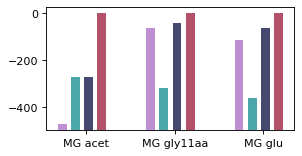

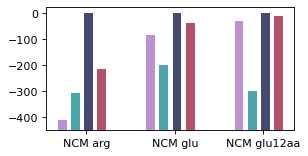

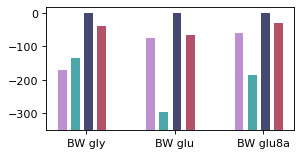

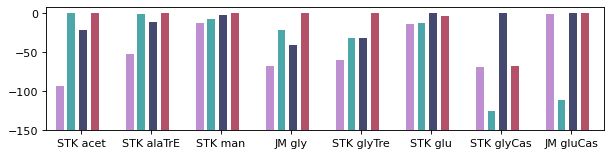

In [22]:
Min = np.min(BIC[1:,1:], axis = 1)
Delta_BIC_DIAM = Min - BIC[1:,1]
Delta_BIC_RDAM = Min - BIC[1:,2]
Delta_BIC_CPM = Min - BIC[1:,3]
Delta_BIC_CAM = Min - BIC[1:,4]

color = ['#BE8FD1', '#4BA7AA', '#45496F', '#B35169']

index = np.arange(3)
bottom = 500
plt.figure(figsize=(4, 2), dpi=80)
plt.bar(np.arange(3), Delta_BIC_DIAM[index] + bottom, width = 0.1, color = color[0], bottom = - bottom)
plt.bar(np.arange(3)+0.15, Delta_BIC_RDAM[index] + bottom, width = 0.1, color = color[1], bottom = - bottom)
plt.bar(np.arange(3)+0.3, Delta_BIC_CPM[index] + bottom, width = 0.1, color = color[2], bottom = - bottom)
plt.bar(np.arange(3)+0.45, Delta_BIC_CAM[index] + bottom, width = 0.1, color = color[3], bottom = - bottom)
plt.xticks(np.arange(3)+ 0.275, Labels[0])
plt.savefig('BIC_MG.pdf', format = 'pdf')
plt.show()

index = np.arange(3, 6)
bottom = 450
plt.figure(figsize=(4, 2), dpi=80)
plt.bar(np.arange(3), Delta_BIC_DIAM[index] + bottom, width = 0.1, color = color[0], bottom = - bottom)
plt.bar(np.arange(3)+0.15, Delta_BIC_RDAM[index] + bottom, width = 0.1, color = color[1], bottom = - bottom)
plt.bar(np.arange(3)+0.3, Delta_BIC_CPM[index] + bottom, width = 0.1, color = color[2], bottom = - bottom)
plt.bar(np.arange(3)+0.45, Delta_BIC_CAM[index] + bottom, width = 0.1, color = color[3], bottom = - bottom)
plt.xticks(np.arange(3)+ 0.275, Labels[1])
plt.savefig('BIC_NCM.pdf', format = 'pdf')
plt.show()


index = np.arange(6, 9)
bottom = 350
plt.figure(figsize=(4, 2), dpi=80)
plt.bar(np.arange(3), Delta_BIC_DIAM[index] + bottom, width = 0.1, color = color[0], bottom = - bottom)
plt.bar(np.arange(3)+0.15, Delta_BIC_RDAM[index] + bottom, width = 0.1, color = color[1], bottom = - bottom)
plt.bar(np.arange(3)+0.3, Delta_BIC_CPM[index] + bottom, width = 0.1, color = color[2], bottom = - bottom)
plt.bar(np.arange(3)+0.45, Delta_BIC_CAM[index] + bottom, width = 0.1, color = color[3], bottom = - bottom)
plt.xticks(np.arange(3)+ 0.275, Labels[2])
plt.savefig('BIC_BW.pdf', format = 'pdf')
plt.show()

index = np.arange(9, 17)
bottom = 150
plt.figure(figsize=(9, 2), dpi=80)
plt.bar(0.9*np.arange(8), Delta_BIC_DIAM[index] + bottom, width = 0.1, color = color[0], bottom = - bottom)
plt.bar(0.9*np.arange(8)+0.15, Delta_BIC_RDAM[index] + bottom, width = 0.1, color = color[1], bottom = - bottom)
plt.bar(0.9*np.arange(8)+0.3, Delta_BIC_CPM[index] + bottom, width = 0.1, color = color[2], bottom = - bottom)
plt.bar(0.9*np.arange(8)+0.45, Delta_BIC_CAM[index] + bottom, width = 0.1, color = color[3], bottom = - bottom)
plt.xlim(-0.17, 7)
plt.xticks(0.9*np.arange(8)+ 0.275, Labels[3])
plt.savefig('BIC_STKJM.pdf', format = 'pdf')
plt.show()

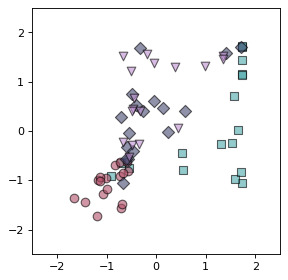

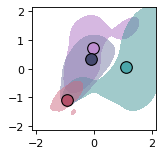

In [23]:
Wass_dist_vb_mean = Wass_dist_vb[:, :, 0]
Wass_dist_vb_mean_renorm = (Wass_dist_vb_mean - np.mean(Wass_dist_vb_mean, axis = 1)[:,None])/np.std(Wass_dist_vb_mean, axis = 1)[:,None]
Wass_dist_vi_mean = Wass_dist_vi[:, :, 0]
Wass_dist_vi_mean_renorm = (Wass_dist_vi_mean - np.mean(Wass_dist_vi_mean, axis = 1)[:,None])/np.std(Wass_dist_vi_mean, axis = 1)[:,None]
#Lamb = [0.08, 0.21, 0.23, 0.26, 0.27, 0.30, 0.38, 0.41, 0.45, 0.51, 0.57, 0.7, 0.83, 0.92, 1, 1.46] 

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(Wass_dist_vb_mean_renorm[:,1], Wass_dist_vi_mean_renorm[:,1], c = '#4BA7AA', marker='s', s = 60, edgecolors = 'k', alpha = 0.6)
plt.scatter(Wass_dist_vb_mean_renorm[:,3], Wass_dist_vi_mean_renorm[:,3], c = '#B35169', marker='o', s = 60, edgecolors = 'k', alpha = 0.6)
plt.scatter(Wass_dist_vb_mean_renorm[:,2], Wass_dist_vi_mean_renorm[:,2], c = '#45496F', marker='D', s = 60, edgecolors = 'k', alpha = 0.6)
plt.scatter(Wass_dist_vb_mean_renorm[:,0], Wass_dist_vi_mean_renorm[:,0], c = '#BE8FD1', edgecolors = 'k', marker='v', s = 60, alpha = 0.6)
plt.ylim(-2.5, 2.5)
plt.xlim(-2.5, 2.5)
plt.savefig('Wassplt1_2.pdf', format = 'pdf')
plt.show()


thr = 0.4

plt.figure(figsize=(2, 2), dpi=80)
sns.kdeplot(x=Wass_dist_vb_mean_renorm[:,0], y=Wass_dist_vi_mean_renorm[:,0], fill = True, color = '#BE8FD1', levels = 2, thresh = thr, alpha = 0.5)
sns.kdeplot(x=Wass_dist_vb_mean_renorm[:,1], y=Wass_dist_vi_mean_renorm[:,1], fill = True, color = '#4BA7AA', levels = 2, thresh = thr, alpha = 0.5)
sns.kdeplot(x=Wass_dist_vb_mean_renorm[:,2], y=Wass_dist_vi_mean_renorm[:,2], fill = True, color = '#45496F', levels = 2, thresh = thr, alpha = 0.55)
sns.kdeplot(x=Wass_dist_vb_mean_renorm[:,3], y=Wass_dist_vi_mean_renorm[:,3], fill = True, color = '#B35169', levels = 2, thresh = thr, alpha = 0.5)
plt.scatter(np.mean(Wass_dist_vb_mean_renorm[:,0]), np.mean(Wass_dist_vi_mean_renorm[:,0]), edgecolors = 'k', c = '#BE8FD1', marker='o', s=110)
plt.scatter(np.mean(Wass_dist_vb_mean_renorm[:,1]), np.mean(Wass_dist_vi_mean_renorm[:,1]), edgecolors = 'k', c = '#4BA7AA', marker='o', s=110)
plt.scatter(np.mean(Wass_dist_vb_mean_renorm[:,2]), np.mean(Wass_dist_vi_mean_renorm[:,2]), edgecolors = 'k', c = '#45496F', marker='o', s=110)
plt.scatter(np.mean(Wass_dist_vb_mean_renorm[:,3]), np.mean(Wass_dist_vi_mean_renorm[:,3]), edgecolors = 'k', c = '#B35169', marker='o', s=110)
plt.ylim(-2.15, 2.15)
plt.xlim(-2.15, 2.15)
plt.savefig('Wassplt2.pdf', format = 'pdf')
plt.show()

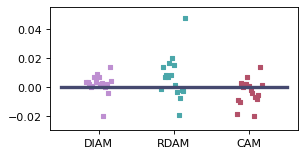

In [24]:
Wass_dist_lamb_mean = Wass_dist_lamb[:, :, 0]
Diff_to_CPM_Wass_dist_lamb_mean = Wass_dist_lamb_mean - Wass_dist_lamb_mean[:,2][:,None]
plt.figure(figsize=(4, 2), dpi=80)
plt.plot([-0.5, 4], [0, 0], color = '#45496F', linewidth = 3)
plt.scatter(np.linspace(0, 0.5, 17), Diff_to_CPM_Wass_dist_lamb_mean[:,0], c = '#BE8FD1', marker='s', s=8)
plt.scatter(np.linspace(0, 0.5, 17)+1.5, Diff_to_CPM_Wass_dist_lamb_mean[:,1], c = '#4BA7AA', marker='s', s=8)
plt.scatter(np.linspace(0, 0.5, 17)+3, Diff_to_CPM_Wass_dist_lamb_mean[:,3], c= '#B35169', marker='s', s=8)
plt.ylim(-0.03, 0.055)
plt.xticks(1.5*np.arange(3)+0.25, ['DIAM', 'RDAM', 'CAM'])
plt.savefig('Wasspltlamb.pdf', format = 'pdf')

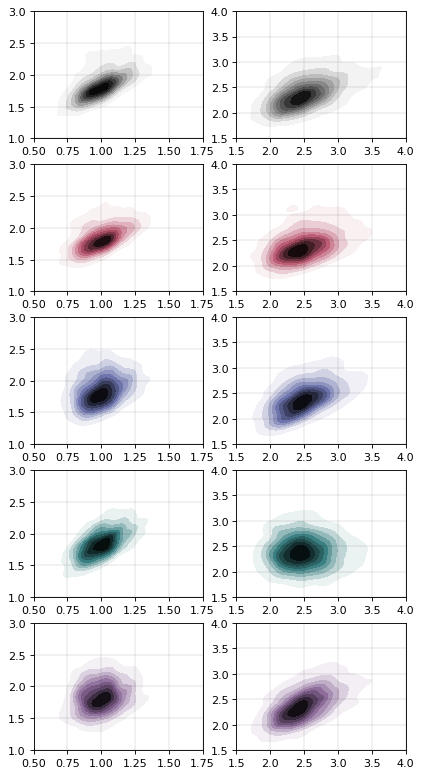

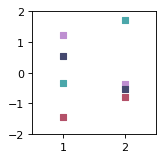

In [25]:
custom_cmap_data = LinearSegmentedColormap.from_list('name', colors = ('w','k'), N=256)
custom_cmap_DIAM = LinearSegmentedColormap.from_list('name', colors = ('w', '#896696', 'k'), N=256)
custom_cmap_RDAM = LinearSegmentedColormap.from_list('name', colors = ('w', '#387D80', 'k'), N=256)
custom_cmap_CPM = LinearSegmentedColormap.from_list('name', colors = ('w', '#686FA8', 'k'), N=256)
custom_cmap_CAM = LinearSegmentedColormap.from_list('name', colors = ('w', '#B8536C', 'k'), N=256)

def simu_DIAM(v, param):
    [a, c, scale]  = param
    Delta_d = stats.gengamma.rvs(size = (N,1), a = a, c = c, scale = scale)
    return (v + Delta_d)/2.

def simu_RDAM(v_tild, param):
    [a, c, scale]  = param
    Delta_id = stats.gengamma.rvs(size = (N,1), a = a, c = c, scale = scale)
    return v_tild + Delta_id


def simu_CPM(v, v_tild, lamb, param):
    [a_d, s_d, a_r, s_r]  = param
    R = stats.gamma.rvs(size = (N,1), a = a_r, scale = s_r)
    Delta_d = stats.lognorm.rvs(size = (N,1), s = a_d, scale = s_d)
    return np.maximum(v_tild*np.exp(lamb*R), (v + Delta_d)/2.)

def simu_CAM(v, v_tild, param):
    [a_d, s_d, a_id, s_id]  = param
    Delta_id = stats.gamma.rvs(size = (N,1), a = a_id, scale = s_id)
    Delta_d = stats.lognorm.rvs(size = (N,1), s = a_d, scale = s_d)
    return np.maximum(v_tild + Delta_id, (v + Delta_d)/2.)

W_v_tild = []
W_v = []

plt.figure(figsize=(6, 12), dpi=80)
for j in [0, 2]:
    np.random.seed(123)
    [v, v_tild, V, TCD] = DATA[0][j]
    N = np.size(v)
    lamb = np.log(V/v_tild)/TCD
    Vbsim_DIAM = simu_DIAM(v, Estimated_parameters[0][j][0])
    Vbsim_RDAM = simu_RDAM(v_tild, Estimated_parameters[0][j][1])
    Vbsim_CPM = simu_CPM(v, v_tild, lamb, Estimated_parameters[0][j][2])
    Vbsim_CAM = simu_CAM(v, v_tild, Estimated_parameters[0][j][3])
    if j == 0:
        x = v_tild.flatten()
        m = 0
        W_v_tild.append(wasserstein_distance(np.concatenate((Vbsim_DIAM, v_tild), axis = 1), np.concatenate((V, v_tild), axis = 1)))
        W_v_tild.append(wasserstein_distance(np.concatenate((Vbsim_RDAM, v_tild), axis = 1), np.concatenate((V, v_tild), axis = 1)))
        W_v_tild.append(wasserstein_distance(np.concatenate((Vbsim_CPM, v_tild), axis = 1), np.concatenate((V, v_tild), axis = 1)))
        W_v_tild.append(wasserstein_distance(np.concatenate((Vbsim_CAM, v_tild), axis = 1), np.concatenate((V, v_tild), axis = 1)))
        ylim = (1,3)
        xlim = (0.5, 1.75)
    else : 
        x = v.flatten()
        m = 1
        W_v.append(wasserstein_distance(np.concatenate((Vbsim_DIAM, v), axis = 1), np.concatenate((V, v), axis = 1)))
        W_v.append(wasserstein_distance(np.concatenate((Vbsim_RDAM, v), axis = 1), np.concatenate((V, v), axis = 1)))
        W_v.append(wasserstein_distance(np.concatenate((Vbsim_CPM, v), axis = 1), np.concatenate((V, v), axis = 1)))
        W_v.append(wasserstein_distance(np.concatenate((Vbsim_CAM, v), axis = 1), np.concatenate((V, v), axis = 1)))
        ylim = (1.5,4)
        xlim = (1.5,4)
        
    plt.subplot(5, 2 , 1+m)
    sns.kdeplot(x=x, y=V.flatten(), fill = True, cmap=custom_cmap_data)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.subplot(5, 2 , 3+m)
    sns.kdeplot(x=x, y=Vbsim_CAM.flatten(), fill = True, cmap=custom_cmap_CAM)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.subplot(5, 2 , 5+m)
    sns.kdeplot(x=x, y=Vbsim_CPM.flatten(), fill = True, cmap=custom_cmap_CPM)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)
    
    plt.subplot(5, 2 , 7+m)
    sns.kdeplot(x=x, y=Vbsim_RDAM.flatten(), fill = True, cmap=custom_cmap_RDAM)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.subplot(5, 2 , 9+m)
    sns.kdeplot(x=x, y=Vbsim_DIAM.flatten(), fill = True, cmap=custom_cmap_DIAM)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)

plt.savefig('plot_empirical_distrib.pdf', format = 'pdf')
plt.show()


W_v_tild = np.array(W_v_tild)
W_v = np.array(W_v)
W_v_tild = (W_v_tild - np.mean(W_v_tild))/np.std(W_v_tild)
W_v = (W_v - np.mean(W_v))/np.std(W_v)

plt.figure(figsize=(2, 2), dpi=80)
plt.scatter([1], W_v_tild[0], c = '#BE8FD1', marker = 's')
plt.scatter([1], W_v_tild[1], c = '#4BA7AA', marker = 's')
plt.scatter([1], W_v_tild[2], c = '#45496F', marker = 's')
plt.scatter([1], W_v_tild[3], c = '#B35169', marker = 's')
plt.scatter([2], W_v[0], c = '#BE8FD1', marker = 's')
plt.scatter([2], W_v[1], c = '#4BA7AA', marker = 's')
plt.scatter([2], W_v[2], c = '#45496F', marker = 's')
plt.scatter([2], W_v[3], c = '#B35169', marker = 's')
plt.xlim(0.5, 2.5)
plt.ylim(-2, 2)
plt.savefig('Wassplt3.pdf', format = 'pdf')
plt.show()


# Simulation CAM with oscillating $\Delta_i$

We introduce a function able to collect $\Delta_i$ observations for data of Si et al. This function takes into argument the original data of Si et al. (e.g. data_si_mg_acet).

In [26]:
def Delta_i_observations_si(data):
    index = np.where(data[1:, data[0] == 'cell ID'] == data[0:-1, data[0] == 'daughter ID'])[0]
    vi_1 = data[index, data[0] == 'initiation size per ori (micron)']
    vi_2 = data[index+1, data[0] == 'initiation size per ori (micron)']
    return vi_2 - vi_1/2.

In [27]:
def perturb_funct(T):
    T_rescaled = 0.5*T*lamb/np.log(2)
    return np.where((T_rescaled > 5)&(np.floor(T_rescaled - 1)%2 == 0), fact_pert, 1)
    
def simu_Delta_i_Perturbed(ti):
    Nsample = np.size(ti)
    return stats.gamma.rvs(size = (1, Nsample), a = a_i, scale = s_i*perturb_funct(ti))
            
Delta_i_obs = Delta_i_observations_si(data_si_mg_glu).astype(float)
a_i,_, s_i = stats.gamma.fit(Delta_i_obs.flatten(), floc = 0)
a_d, s_d, a_id, s_id = Estimated_parameters[0][2][3]

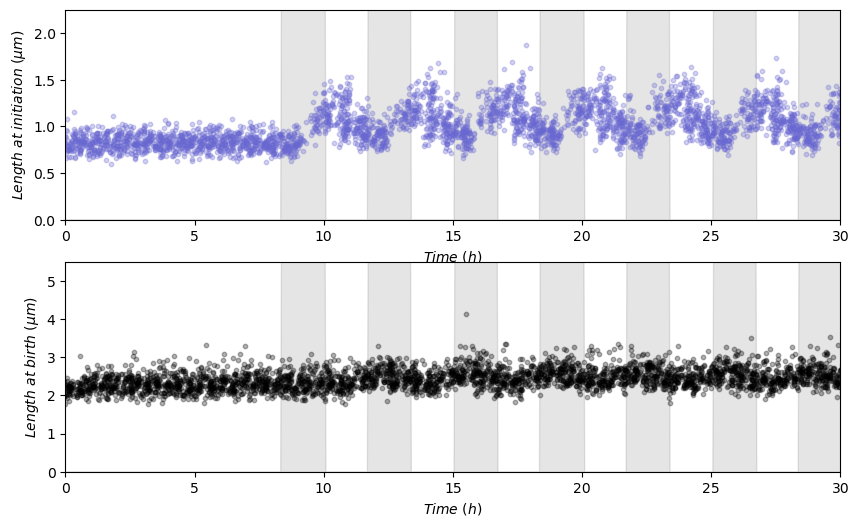

In [28]:
np.random.seed(123)
lamb = 0.83
Nb_lineages = 100
Nb_gen = 40
fact_pert = 1.75
Vi = stats.gamma.rvs(size = (1, Nb_lineages), a = 3*a_i, scale = s_i/3.)
Vb = Vi + stats.gamma.rvs(size = (1, Nb_lineages), a = a_id, scale = s_id)
Ti = -(np.random.rand(1, Nb_lineages)+1)*np.log(2)/lamb
Tb = Ti + np.log(Vb/Vi)/lamb



for i in range(Nb_gen):
    Div = (Vb[-1, :] + stats.lognorm.rvs(size = (1, Nb_lineages), s = a_d, scale = s_d))/2.
    Rep = Vi[-1, :] + stats.gamma.rvs(size = (1, Nb_lineages), a = a_id, scale = s_id)
    Vb_new = np.maximum(Div, Rep)
    Vi_new = (Vi[-1, :] +  simu_Delta_i_Perturbed(Ti[-1, :]))/2.
    Tb_new = Tb[-1, :] + np.log(2*Vb_new/Vb[-1, :])/lamb
    Ti_new = Ti[-1, :] + np.log(2*Vi_new/Vi[-1, :])/lamb
    Vb = np.concatenate((Vb, Vb_new), axis = 0)
    Tb = np.concatenate((Tb, Tb_new), axis = 0)
    Vi = np.concatenate((Vi, Vi_new), axis = 0)
    Ti = np.concatenate((Ti, Ti_new), axis = 0)
    

TT = np.linspace(0, 30, 600)

region_pert = np.where(Ti[:-1, :] > 5*np.log(2)/lamb)

plt.figure(figsize = (10,6))

plt.subplot(211)
plt.fill_between(TT, np.zeros(600), (perturb_funct(TT)-1)*6, color ='k', alpha = 0.1) 
plt.scatter(Ti, Vi, color = '#6968D1', s = 10, alpha = 0.3)
plt.xlim([0, 30])
plt.ylim([0, 2.25])
plt.ylabel('$Length$ $at$ $initiation$ ($\mu m$)')
plt.xlabel('$Time$ ($h$)')


plt.subplot(212)
plt.fill_between(TT, np.zeros(600), (perturb_funct(TT)-1)*13, color ='k', alpha = 0.1) 
plt.scatter(Tb, Vb, color = 'k', s = 10, alpha = 0.3)
plt.ylabel('$Length$ $at$ $birth$ ($\mu m$)')
plt.xlabel('$Time$ ($h$)')
plt.xlim([0, 30])
plt.ylim([0, 5.5])
plt.savefig('sim_oscill_CAM.pdf', format = 'pdf')


## Codes for Figure 2

In [29]:
def extract_donnees2(data_or_cdt, author):
    if author == 'si':
        Delta_i = Delta_i_observations_si(data_or_cdt).astype(float)
        v = data_or_cdt[1:, data_or_cdt[0] == 'newborn size (micron)'].astype(float)
        V = data_or_cdt[1:, data_or_cdt[0] == 'division size (micron)'].astype(float)
        Delta_d = V-v
        return [Delta_d.T[0], Delta_i]
    
    elif author == 'witz':
        data = data_witz[data_witz[condition] == data_or_cdt]
        data = data.dropna(subset = (dLambda_id, dLambda_if))
        data = data.to_numpy()
        data = data[:,:-1].astype(float)
        Delta_i = data[:, dLambda_if]
        Delta_d = data[:, dL]
        return [Delta_d, Delta_i]

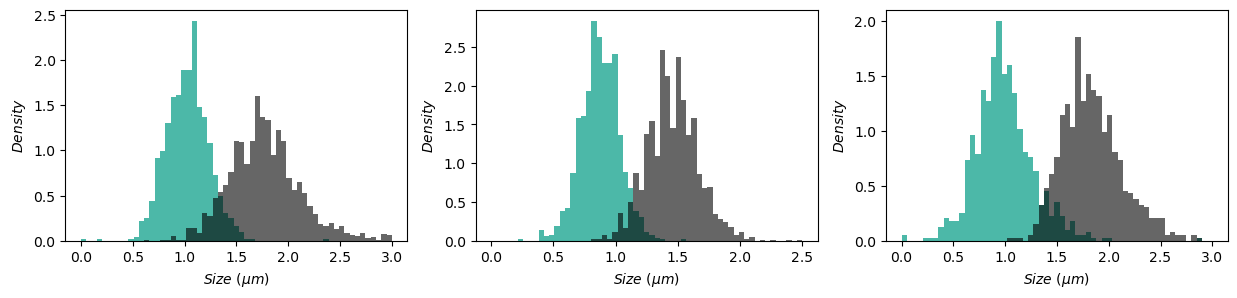

In [30]:
plt.figure(figsize = (15,3))
plt.subplot(131)
[Delta_d, Delta_i] = extract_donnees2(data_si_mg_acet, 'si')
binn = np.linspace(0, 3, 60)
plt.hist(Delta_i, binn, color = '#009B83', alpha = 0.7, density = True, label = '$\Delta_i$')
plt.hist(Delta_d, binn, color = 'k', alpha = 0.6, density = True, label = '$\Delta_d$')

plt.ylabel("$Density$")
plt.xlabel("$Size$ ($\mu m$)")
plt.subplot(132)
[Delta_d, Delta_i] = extract_donnees2(data_si_ncm_arg, 'si')
binn = np.linspace(0, 2.5, 60)
plt.hist(Delta_i, binn, color = '#009B83', alpha = 0.7, density = True, label = '$\Delta_i$')
plt.hist(Delta_d, binn, color = 'k', alpha = 0.6, density = True, label = '$\Delta_d$')

plt.ylabel("$Density$")
plt.xlabel("$Size$ ($\mu m$)")
plt.subplot(133)
[Delta_d, Delta_i] = extract_donnees2('glycerol', 'witz')
binn = np.linspace(0, 3, 60)
plt.hist(Delta_i, binn, color = '#009B83', alpha = 0.7, density = True, label = '$\Delta_i$')
plt.hist(Delta_d, binn, color = 'k', alpha = 0.6, density = True, label = '$\Delta_d$')

plt.ylabel("$Density$")
plt.xlabel("$Size$ ($\mu m$)")
plt.savefig('fig_overlap_densities_Delta.pdf', format = 'pdf')

In [31]:
def MonteCarlo_proba_DIAM(data_or_cdt, author, nb_sim):
    [Delta_d, Delta_i] = extract_donnees2(data_or_cdt, author)
    f_Dd = stats.gaussian_kde(Delta_d)
    f_Di = stats.gaussian_kde(Delta_i)
    Vb = f_Dd.resample(size=nb_sim)
    Vi = f_Di.resample(size=nb_sim)
    for loop in range(100):
        Vb = (Vb + f_Dd.resample(size=nb_sim))/2.
        Vi = (Vi + f_Di.resample(size=nb_sim))/2.
    Vb = np.reshape(Vb, (1, nb_sim))
    Vi = np.reshape(Vi, (1, nb_sim))
    Vb = np.concatenate((Vb, np.ones((1, nb_sim))), axis = 0)
    Vi = np.concatenate((Vi, np.zeros((1, nb_sim))), axis = 0)
    Total = np.concatenate((Vb, Vi), axis = 1)
    i = np.argsort(Total[0])
    Total = Total[:,i]
    s = np.sum(np.arange(1, 2*nb_sim + 1)*Total[1])
    plt.subplot
    plt.hist(Vb[0], [0.01*k for k in range(300)], color = 'k', density = True, alpha = 0.5)
    plt.hist(Vi[0], [0.01*k for k in range(300)], color = 'b', density = True, alpha = 0.5)
    print(1 + nb_sim*(nb_sim+1)/(2 * nb_sim**2) - s/nb_sim**2) # Wilcoxon strategy

0.0007711209240000017
7.027815299998075e-05
0.0011510402940000386


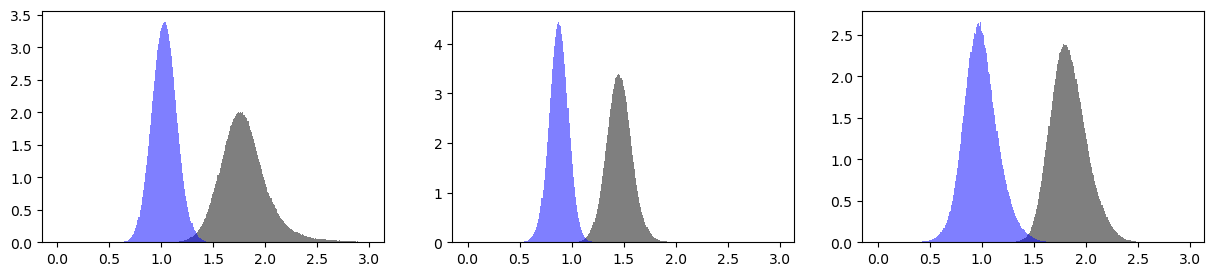

In [32]:
plt.figure(figsize = (15,3))
plt.subplot(131)
MonteCarlo_proba_DIAM(data_si_mg_acet, 'si', 1000000)
plt.subplot(132)
MonteCarlo_proba_DIAM(data_si_ncm_arg, 'si', 1000000)
plt.subplot(133)
MonteCarlo_proba_DIAM('glycerol', 'witz', 1000000)
plt.savefig('fig_overlap_densities_Vinfty.pdf', format = 'pdf')